# Neural Network Implementation-From Scratch

## A. Neural Network: Binary Classification 

In this assignment, we will learn to build a fully-connected neural network with standard architecture, i.e., only one hidden layer. We will use the `Breast cancer wisconsin (diagnostic) dataset` available in `https://scikit-learn.org/stable/datasets/index.html`. It has a total of 569 sample with two classes (Malignant and Benign). Each sample has 30 real-valued features. 

**This assignment will help you understand and implement:**
- A neural network for binary classification consisting of one hidden layer with non-linear activation. You will implement ideas like forward propogation, computing the loss, bagward propogation, and parameter(weights) update. Using the trained network, you will learn to predict a class given the features of a sample.

**Note:** There are multiple conventions for coding neural networks. We will follow the conventions suggested by Andrew Ng: https://www.coursera.org/learn/neural-networks-deep-learning



In [61]:
# Package imports
import numpy as np
import sklearn
import sklearn.linear_model
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

## 1. Loading the dataset and preprocessing

In [62]:
X, y = load_breast_cancer(return_X_y=True)
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size =0.2, random_state=0)

In [63]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

### Reshaping the data 

In [64]:
trainx = train_data.T
trainy = train_labels.reshape(-1,1).T

testx = test_data.T
testy =test_labels.reshape(-1,1).T

In [65]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((30, 455), (1, 455), (30, 114), (1, 114))

In [66]:
X=trainx
Y=trainy

In [67]:
### START CODE HERE ###
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]  # training set size
### END CODE HERE ###

print ('No. of training samples: ' + str(m))
print ('Number of features per sample: ' + str(shape_X[0]))

No. of training samples: 455
Number of features per sample: 30


## 2 - Neural Network model

We will train a Neural Network with a single hidden layer.

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & {if } a^{[2](i)} > 0.5 \\ 0 & {otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost (loss) $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Important**: Building the NN will involve the following:

    1. Specify the network structure in terms of the number of input units, number of neurons in the hidden units, ...
    2. Initialize the parameters of the model
    3. Loop a number of iterations:
        - Forward propagation
        - Compute loss and the overall loss
        - Backward propagation
        - Update the parameters (gradient descent)

In order to make the code modular, we can implement each of the step as a function and them combine them together to build the overall model.

### 2.1 - Specify the network structure 
    - n_x: input layer size
    - n_h: #neurons in  hidden layer (hard code a value, say 10) 
    - n_y: the size of the output layer

In [68]:
def model_architecture(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### 
    n_x = X.shape[0] # size of input layer
    n_h = 10
    n_y = len(np.unique(Y)) - 1 # number ofsize of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

### 2.2 - Initialize the parameters of the model

- Initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- Initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [69]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2)

    
    ### START CODE HERE ###
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 2.3 - The Loop ####

**Instructions**:
- Look above at the mathematical representation of your classifier.
- Define the function `sigmoid()`.
- You can use the function `np.tanh()`. It is part of the numpy library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [70]:
def sigmoid(x):
    ### Update THE CODE HERE ###
    x = 1/(1+np.exp(-x))
    return x
    ### END CODE HERE ###

In [71]:
def forward_propagation(X, parameters, a1=np.tanh, a2= sigmoid):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### 
    Z1 = W1 @ X
    A1 = a1(Z1)
    Z2 = W2 @ A1
    A2 = a2(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

Now you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the loss function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{7}$$

- Implement the cross-entropy loss:
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
loss = - np.sum(logprobs)
```

In [72]:
def cross_entropy_loss(A2,Y):
    logprobs = np.multiply(np.log(A2),Y)
    loss = -1 * np.sum(logprobs)
    return loss

In [73]:
def compute_loss(A2, Y, loss_function = cross_entropy_loss):
    """
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
       
    Returns:
    loss -- cross-entropy loss given equation (7)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy loss
    ### START CODE HERE ###
    loss = loss_function(A2,Y)
    ### END CODE HERE ###
    
    loss = float(np.squeeze(loss))

    assert(isinstance(loss, float))
    
    return loss

Using the cache computed during forward propagation, we can now implement backward propagation.

Backpropagation is usually the hardest (most mathematical) part. You can use the following six equations as vectorized implementation:

$$dZ^{[2]} = A^{[2]} - Y \tag{8}$$ 
$$dW^{[2]} = \frac{1}{m} dZ^{[2]}A^{[1]{T}} \tag{9}$$ 
$$db^{[2]} = \frac{1}{m} np.sum(dZ^{[2]}, axis = 1, keepdims = True)\tag{10}$$ 
$$dZ^{[1]} = W^{[2]T}dZ^{[2]}*g^{[1]'}(Z^{[1]}) \tag{11}$$ 
$$dW^{[1]} = \frac{1}{m} dZ^{[1]}X^{{T}} \tag{12}$$ 
$$db^{[1]} = \frac{1}{m} np.sum(dZ^{[1]}, axis = 1, keepdims = True)\tag{13}$$ 

- $*$ denotes elementwise multiplication.
- Notations followed:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
   
- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [74]:
def backprop(parameters, cache, X, Y):
    """
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data
    Y -- "true" labels
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### 
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### 
    A1 = cache['A1']
    A2 = cache['A2']
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### 
    dZ2 = A2 - Y
    dW2 = ((1/m)* dZ2) @ A1.T
    db2 = (1/m)* np.sum(dZ2, axis=1, keepdims=True)
    #possible problem
    dZ1 = ( W2.T @ dZ2 ) * (1 - np.power(A1,2))
    dW1 = (1/m)*dZ1@ X.T
    db1 = (1/m)* np.sum(dZ1, axis=1, keepdims=True)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**Gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.




In [75]:
def update(parameters, grads, learning_rate = 0.01):
    """
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    learning_rate -- The learning rate
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### 
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### 
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 2.4 - Integrate parts 2.1, 2.2 and 2.3 in NeuralNetwork() ####

Build your neural network model in `NeuralNetwork()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [76]:
def NeuralNetwork(X, Y, n_h, num_iterations = 10000, learning_rate = 0.01, print_loss=False, a1=np.tanh, a2=sigmoid, loss_function = cross_entropy_loss):
    """
    Arguments:
    X -- dataset
    Y -- labels 
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    learning_rate -- The learning rate
    print_loss -- if True, print the loss every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to make predictions.
    """
    
    np.random.seed(3)
    n_x = model_architecture(X, Y)[0]
    n_y = model_architecture(X, Y)[2]
    
    # Initialize parameters
    ### START CODE HERE ### 
    parameters = initialize_parameters(n_x,n_h,n_y)
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### 
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters, a1=a1, a2= a2)
        
        # loss function. Inputs: "A2, Y, parameters". Outputs: "loss".
        loss = compute_loss(A2,Y, loss_function = loss_function)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backprop(parameters,cache,X,Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters =  update(parameters,grads)
        
        ### END CODE HERE ###
        
        # Print the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ("loss after iteration %i: %f" %(i, loss))

    return parameters

### 2.5 Predictions

Use your model to predict by building predict().

**Reminder**: $ predictions = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [77]:
def predict(parameters, X):
    """
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data 
    
    Returns
    predictions -- vector of predictions of our model
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### 
    A2, cache = forward_propagation(X, parameters)
    predictions = np.where(A2> 0.5, 1 , 0)
    ### END CODE HERE ###
    
    return predictions

## 3. Model Execution
It is time to run the model and see how it performs on the dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

In [78]:
# Build a model with a n_h-dimensional hidden layer
parameters = NeuralNetwork(trainx, trainy, 5, num_iterations = 100000, learning_rate = 0.01, print_loss=True)

loss after iteration 0: 200.949495
loss after iteration 100: 199.343186
loss after iteration 200: 185.530896
loss after iteration 300: 148.719538
loss after iteration 400: 110.707548
loss after iteration 500: 83.261527
loss after iteration 600: 65.143750
loss after iteration 700: 53.196355
loss after iteration 800: 44.957613
loss after iteration 900: 39.013066
loss after iteration 1000: 34.557922
loss after iteration 1100: 31.111772
loss after iteration 1200: 28.374280
loss after iteration 1300: 26.150190
loss after iteration 1400: 24.308265
loss after iteration 1500: 22.757701
loss after iteration 1600: 21.434017
loss after iteration 1700: 20.290334
loss after iteration 1800: 19.291838
loss after iteration 1900: 18.412169
loss after iteration 2000: 17.631012
loss after iteration 2100: 16.932463
loss after iteration 2200: 16.303890
loss after iteration 2300: 15.735130
loss after iteration 2400: 15.217910
loss after iteration 2500: 14.745427
loss after iteration 2600: 14.312030
loss aft

## Check the accuracy on the training set

In [79]:
# Print accuracy
predictions = predict(parameters, trainx)
print(accuracy_score(Y.T, predictions.T))

1.0


## Check the accuracy on the test set

In [80]:
predictions_test = predict(parameters,testx)
print(accuracy_score(testy.T, predictions_test.T))

0.9736842105263158


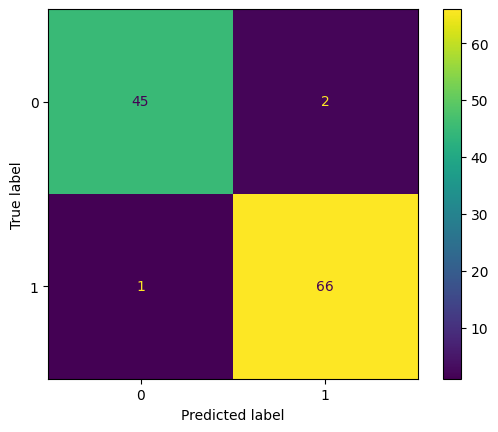

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(testy.T, predictions_test.T)
ConfusionMatrixDisplay(confusion).plot()

## Run the model multiple times with different hyperparameters and write your interpretation


#### Preform a simple grid search

In [82]:
params = {'learning_rate': (0.01, 0.05, 0.1),
        'a1': (np.tanh, lambda x: np.where(x>0, 1 , 0), sigmoid),
        'n_h' : range(1,15,2)
}

results = {}
for lr in params['learning_rate']:
    for a1 in params['a1']:
        for n_h in params['n_h']:
                parameters = NeuralNetwork(trainx, trainy, n_h= n_h, num_iterations = 1000, learning_rate = lr, print_loss=False, a1=a1, a2=sigmoid, loss_function = cross_entropy_loss)
                predictions_test = predict(parameters, testx)
                results[(lr, a1.__name__, n_h)] = accuracy_score(testy.T, predictions_test.T)

print(max(results,  key= lambda x: results[x]))

(0.01, 'tanh', 1)


##### Q:What happens when you change the tanh activation for a sigmoid activation or a ReLU activation?

### `The results of the grid search implies that adding more neurons in the hidden layer raises the possibility of overfitting.`
### `hence, the optimal hyperparmeters selection to this problems is:`
* `learning_rate` = 0.01
* `activation_function1` = tanh
* `num_of_neurons in the hidden layer` = 1
